In [317]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [323]:
li = pd.read_csv('../00_originalData/li_country_industry_det_skill_2016.tsv', sep='\t')

In [324]:
li.shape
li.head()
li['skill_id'].drop_duplicates().shape

(2457353, 9)

,country_sk,industry_sk,skill_id,std_skill_name,hire_ct,skill_member_ct,member_ct,penetration_rate,hiring_rate
0,239,96,1101,public speaking,3,34,192,0.17708,0.08824
1,239,-9,1164,instructional design,3,64,10731,0.00596,0.04688
2,239,57,1004,completion,3,117,746,0.15684,0.02564
3,239,-9,344,administrative assistance,5,79,10731,0.00736,0.06329
4,239,-9,3526,water quality,0,35,10731,0.00326,0.00000


(32835,)

In [325]:
#Global pen rates (limit to those with at least 1%)

ind2016 = li.copy()

def stratSkills(df=None, inWhat=None):
    
    skillTotals = df.groupby('std_skill_name').agg({'skill_member_ct' : 'sum'}).rename({'skill_member_ct' : 'penRate'}, axis=1)
    memTotal = df.groupby(['country_sk', inWhat + '_sk']).agg({'member_ct' : 'max'}).sum().rename({'member_ct' : 'penRate'})
    penRate = skillTotals / memTotal
    return penRate

indStrat2016 = stratSkills(ind2016, inWhat='industry')
ind2016drop = indStrat2016[indStrat2016['penRate'] < 0.01]

li = pd.merge(li, ind2016drop.reset_index(), on='std_skill_name', how='outer', indicator=True)
li._merge.value_counts()
li = li[li['_merge'] != 'both']
li.drop(['penRate', '_merge'], axis=1, inplace=True)
li['skill_id'].drop_duplicates().shape

both          1725557
left_only      731796
right_only          0
Name: _merge, dtype: int64

(230,)

In [332]:
temp = li.groupby('std_skill_name').agg({'skill_member_ct' : 'sum'}).sort_values(by='skill_member_ct', ascending=False)
print('Top 10 skills by member count (w global pen rate > 1%)')
temp.head(10)
print('Bottom 10 skills by member count (w global pen rate > 1%)')
temp.tail(10)
del(temp)

Top 10 skills by member count (w global pen rate > 1%)


,skill_member_ct
std_skill_name,
microsoft office,36814750
customer service,30957196
management,29904617
microsoft excel,26704525
project management,21384400
microsoft word,20624936
strategic planning,19381908
leadership,19380579
microsoft powerpoint,17235677


Bottom 10 skills by member count (w global pen rate > 1%)


,skill_member_ct
std_skill_name,
video production,1207708
oil & gas,1200284
administration,1196234
5s,1192164
television,1185521
it management,1181950
commissioning,1175127
media relations,1172538
music,1171005


In [333]:
# Country pen rate (given constraint to > 1% global pen rate)

skillTotal = li.groupby(['country_sk', 'std_skill_name']).agg({'skill_member_ct' : 'sum'})
memTotal = li.groupby('country_sk').agg({'member_ct' : 'max'})

countrySkillPen = memTotal.join(skillTotal, how='inner')
countrySkillPen['penRate'] = countrySkillPen['skill_member_ct'] / countrySkillPen['member_ct']
countrySkillPen.drop(['member_ct', 'skill_member_ct'], axis=1, inplace=True)
countrySkillPen.reset_index(inplace = True)

In [334]:
# Create array with country pen rates (country as index, skills as cols), with zeroes filling blanks

skillPen = countrySkillPen.set_index('country_sk')[['std_skill_name', 'penRate']].pivot(columns='std_skill_name').fillna(0)['penRate']

In [335]:
# Data for complexity indeces

df = pd.read_csv('../02_data/H0_2016.csv')

# Delete some errors (?)
df['commoditycode'] = df['commoditycode'][df['commoditycode'].astype(str) != 'XXXX'].astype(int)

# Data is at product level, eci is constant at country (exporter) level
df = df[['exporter', 'eci']].drop_duplicates()

In [336]:
# This file provides the maping from city in OE data to country sk
# We need this to attach ISO3 country name to our datacolumn with pen
countryMapping = pd.read_csv('../00_originalData/li_country.tsv', sep='\t')
countryMapping = countryMapping[['country_sk', 'country']].drop_duplicates()

# This data provides the ISO3 country name, but must bridge via city in OE to city in LI
bridgeMapping = pd.read_csv('../00_originalData/OE_socioeconomic_statistics_city.csv')
bridgeMapping = bridgeMapping[['Country', 'iso3c']].drop_duplicates()

# With this merge, we get country and iso3 together
iso3mapping = pd.merge(countryMapping, bridgeMapping, left_on='country', right_on='Country', indicator=True, how='outer').drop_duplicates()
for i, j in zip(iso3mapping[iso3mapping['_merge'] == 'left_only']['country'], 
               ['Moldova', 'Russia', 'South Korea', 'Reunion', 'Vietnam', 'Taiwan', 'Palestine', 'Tanzania', 'Democratic Republic of Congo',
                'Hong Kong', 'Libya', "Cote d'Ivoire", 'Trinidad and Tobago', 'Macedonia', 'Iran', 'UAE', 'Syria', 'Mauritius']):
    print(i, '->', j)
    countryMapping.loc[countryMapping['country'] == i, 'country'] = j

iso3mapping = pd.merge(countryMapping, bridgeMapping, left_on='country', right_on='Country', indicator=True, how='outer').drop_duplicates()
iso3mapping._merge.value_counts()
iso3mapping[iso3mapping['_merge'] == 'left_only']['country']
iso3mapping = iso3mapping[iso3mapping['_merge'] == 'both']
iso3mapping.drop(['_merge', 'Country'], axis=1, inplace=True)
iso3mapping.set_index('country_sk', inplace=True)
iso3mapping.drop_duplicates(inplace=True)
iso3mapping.head()

del(countryMapping, bridgeMapping)

Moldova, Republic of -> Moldova
Russian Federation -> Russia
Korea, Republic of -> South Korea
Reunion -> Reunion
Viet Nam -> Vietnam
Taiwan, Province of China -> Taiwan
Palestinian Territory, Occupied -> Palestine
Tanzania, United Republic of -> Tanzania
Congo, the Democratic Republic of the -> Democratic Republic of Congo
Hong Kong -> Hong Kong
Libyan Arab Jamahiriya -> Libya
Côte D'Ivoire -> Cote d'Ivoire
Trinidad and Tobago -> Trinidad and Tobago
Macedonia, the Former Yugoslav Republic of -> Macedonia
Iran, Islamic Republic of -> Iran
United Arab Emirates -> UAE
Syrian Arab Republic -> Syria
Mauritius -> Mauritius


both          134
right_only     25
left_only       6
Name: _merge, dtype: int64

20                 Reunion
29               Palestine
76               Hong Kong
93     Trinidad and Tobago
133                  Syria
138              Mauritius
Name: country, dtype: object

,country,iso3c
country_sk,,
135.0,Morocco,MAR
46.0,Chile,CHL
133.0,Latvia,LVA
14.0,Australia,AUS
91.0,Guatemala,GTM


In [337]:
temp = pd.merge(iso3mapping, skillPen, right_index=True, left_index=True, how='inner')
dfNew = pd.merge(temp.reset_index(), df, left_on='iso3c', right_on='exporter', indicator=True, how='outer').set_index('country_sk')
dfNew._merge.value_counts() # left only is Puerto Rico, right are all NaN ... might have Syria among them
dfNew = dfNew[dfNew['_merge'] == 'both']
dfNew = dfNew[['country', 'eci']]
dfNew.head()
del(temp) 

both          133
right_only     98
left_only       1
Name: _merge, dtype: int64

,country,eci
country_sk,,
135.0,Morocco,-0.774877
46.0,Chile,-0.234883
133.0,Latvia,0.675649
14.0,Australia,-0.235760
91.0,Guatemala,-0.560479


In [338]:
# dfNew has ECI values with the country id's that merged (133)
# skillPen has the penetration rates by country
# penRates joins them all

penRates = pd.merge(skillPen, dfNew, left_index=True, right_index=True, indicator=True, how='outer')
penRates._merge.value_counts()
penRates = penRates[penRates['_merge'] == 'both']
penRates.drop('_merge', axis=1, inplace=True)
penRates.head()

both          133
left_only       9
right_only      0
Name: _merge, dtype: int64

,5s,account management,accounting,accounts payable,active directory,administration,adobe creative suite,adobe illustrator,adobe photoshop,advertising,...,video production,volunteer management,web design,web development,windows,windows server,writing,xml,country,eci
country_sk,,,,,,,,,,,,,,,,,,,,,
2,0.006332,0.131575,0.121648,0.049221,0.021805,0.038625,0.014668,0.026478,0.109500,0.074443,...,0.011289,0.001035,0.018117,0.017325,0.071392,0.026396,0.009669,0.016196,UAE,0.025615
3,0.000000,0.018804,0.075116,0.014016,0.025787,0.033169,0.003841,0.005985,0.094319,0.009676,...,0.010923,0.006734,0.012120,0.012769,0.082149,0.029328,0.009477,0.005237,Afghanistan,-1.254752
6,0.000000,0.032510,0.101873,0.012151,0.018645,0.013068,0.009880,0.020598,0.117809,0.044582,...,0.014741,0.009124,0.027211,0.029004,0.104263,0.034821,0.010239,0.015896,Albania,-0.509574
7,0.000000,0.023140,0.059915,0.007145,0.009243,0.007801,0.010488,0.028909,0.144936,0.037693,...,0.009440,0.009833,0.032055,0.058538,0.069223,0.013045,0.012193,0.087775,Armenia,0.190393
9,0.003251,0.028960,0.068311,0.012637,0.017162,0.012603,0.003218,0.006905,0.077361,0.016759,...,0.003419,0.001274,0.008212,0.004626,0.082724,0.030904,0.001676,0.003352,Angola,-1.193203


In [340]:
def boxcoxTrans(df):
    """
    When passed a DataFrame with only numeric columns and NO zeroes (add 1 to all),
    performs box-cox in each column and returns transformed matrix
    """
    correction = (df + 1).apply(stats.boxcox)
    for rowtocol in np.arange(correction.shape[0]):
        if rowtocol == 0:
            transformed = pd.DataFrame(correction[rowtocol][0], 
                                       columns = [correction.index[rowtocol]], 
                                       index=df.index) 
        else:
            transformed = pd.merge(transformed, pd.DataFrame(correction[rowtocol][0], 
                                            columns = [correction.index[rowtocol]],
                                           index=df.index), left_index=True, right_index=True)
    
    return transformed

In [342]:
temp=penRates.drop(['country', 'eci'], axis=1).apply(stats.skewtest)
print('Ditstibution of p values for skewness test of penetration rate regressors')
pd.Series([i[1] for i in temp]).describe()
print('\n\nSkewness for ECI')
stats.skewtest(penRates['eci'])
print('\n\nDistribution of values for ECI')
penRates['eci'].describe()

Ditstibution of p values for skewness test of penetration rate regressors


count    2.300000e+02
mean     7.602362e-03
std      5.797015e-02
min      1.822894e-38
25%      4.549939e-14
50%      8.630258e-10
75%      2.385970e-06
max      7.593927e-01
dtype: float64



Skewness for ECI


SkewtestResult(statistic=0.38133310956431415, pvalue=0.70295608848045243)



Distribution of values for ECI


count    133.000000
mean      -0.026001
std        1.041920
min       -2.491868
25%       -0.823187
50%       -0.086452
75%        0.773159
max        2.257342
Name: eci, dtype: float64

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(-6.6000000000000005,
 138.59999999999999,
 -4.3638646175854419,
 91.641156969294286)

Text(0.5,0,'n_components')

Text(0,0.5,'explained_variance_')

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([  1,   2, ..., 229, 230]), 'linear__alpha': array([  1.00000e-06,   1.14895e-06, ...,   8.70359e+05,   1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

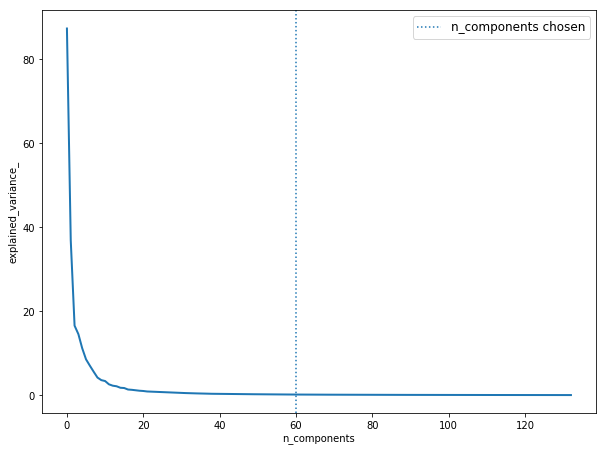

In [222]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

linear = linear_model.Lasso()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])

X_digits = scale(boxcoxTrans(penRates.drop(['country', 'eci'], axis=1)))
y_digits = scale(penRates['eci'])

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(11, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = np.arange(1, X_digits.shape[1] + 1)
alphas = np.logspace(-6, 6, 200)


# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              linear__alpha=alphas))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components, 
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [224]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=0.016638168860761273, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [248]:
temp = pd.DataFrame(X_digits).apply(stats.skewtest)
print('Ditstibution of p values for skewness test of regressors after Box Cox and scaling')
pd.Series([i[1] for i in temp]).describe()
print('\nSkewness for ECI after scaling')
stats.skewtest(y_digits)
print('\nDistribution of values for ECI after scaling')
pd.Series(y_digits).describe()

Ditstibution of p values for skewness test of regressors after Box Cox and scaling


count    2.300000e+02
mean     3.511714e-01
std      2.871108e-01
min      9.662987e-08
25%      1.022375e-01
50%      2.710360e-01
75%      5.538638e-01
max      9.842431e-01
dtype: float64


Skewness for ECI after scaling


SkewtestResult(statistic=0.38133310956431415, pvalue=0.70295608848045243)


Distribution of values for ECI after scaling


count    1.330000e+02
mean     1.669508e-18
std      1.003781e+00
min     -2.375604e+00
25%     -7.680046e-01
50%     -5.823804e-02
75%      7.699066e-01
max      2.199761e+00
dtype: float64

In [237]:
# pcaWin is the PCA bit for the optimal model
pcaWin = decomposition.PCA(n_components=estimator.best_estimator_.steps[0][1].n_components)
pcaWin.fit(X_digits)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

array([ 37.66,  53.56,  60.69,  66.95,  71.76,  75.43,  78.45,  80.85,
        82.65,  84.18,  85.62,  86.73,  87.69,  88.59,  89.34,  90.06,
        90.63,  91.17,  91.66,  92.11,  92.53,  92.9 ,  93.25,  93.58,
        93.89,  94.18,  94.46,  94.72,  94.97,  95.21,  95.43,  95.64,
        95.83,  96.01,  96.18,  96.34,  96.49,  96.63,  96.76,  96.89,
        97.01,  97.13,  97.24,  97.35,  97.46,  97.56,  97.66,  97.75,
        97.84,  97.92,  98.  ,  98.08,  98.16,  98.23,  98.3 ,  98.37,
        98.43,  98.49,  98.55,  98.61])

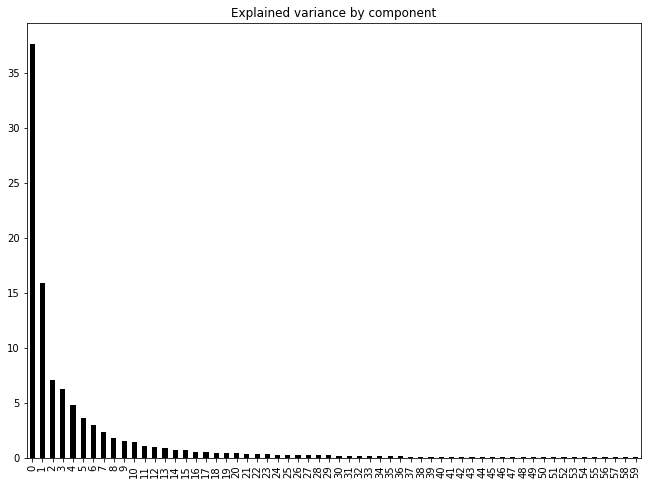

In [314]:
np.cumsum(np.round(pcaWin.explained_variance_ratio_, decimals = 4) * 100)
pd.Series(np.round(pcaWin.explained_variance_ratio_, decimals = 4) * 100).plot(
    kind='bar', figsize=(11,8), colormap='gist_gray', title='Explained variance by component')

In [241]:
# X_pca transforms X_digits under the PCA
X_pca = pcaWin.transform(X_digits)

In [242]:
reg = linear_model.Lasso(alpha=estimator.best_estimator_.steps[1][1].alpha)

In [243]:
fitted = reg.fit(X_pca, y_digits)

In [303]:
temp = pd.DataFrame(np.absolute(fitted.coef_)).rename(columns={0:'absPCA'}
                                                      ).sort_values(ascending=False, by='absPCA')
fitted.coef_[temp[0:8].index]
fitted.coef_.shape

array([-0.09173411, -0.09014562,  0.08901959, -0.08772368,  0.08104743,
       -0.07747949, -0.06918269,  0.05930489])

(60,)

In [351]:
temp = pd.DataFrame(np.absolute(fitted.coef_)).rename(
    columns={0:'absPCA'}).sort_values(ascending=False, by='absPCA')

pc = pd.DataFrame(pcaWin.components_, columns = skillPen.columns, index=fitted.coef_)
pc.index.names = ['pcaCoeff']
pc.iloc[temp[0:8].index]

std_skill_name,5s,account management,accounting,accounts payable,active directory,administration,adobe creative suite,adobe illustrator,adobe photoshop,advertising,...,unix,vendor management,video production,volunteer management,web design,web development,windows,windows server,writing,xml
pcaCoeff,,,,,,,,,,,,,,,,,,,,,
-0.091734,-0.005333,0.009679,-0.039098,-0.022882,-0.169294,0.049777,-0.013845,-0.037643,-0.089929,0.005369,...,0.025853,-0.041812,0.063992,0.012746,0.020346,0.002498,0.118064,-0.041503,0.077931,-0.093669
-0.090146,-0.017610,0.004331,-0.030113,-0.014613,-0.008514,0.052363,0.034271,0.042168,0.056501,0.013366,...,-0.082485,-0.041637,-0.000995,0.078280,0.078364,0.117054,-0.160200,-0.008456,0.055362,0.076557
0.089020,0.016480,-0.008809,0.083898,-0.049303,-0.043043,0.161070,-0.007225,-0.071525,0.041800,-0.068573,...,-0.045571,0.050473,0.078534,0.004851,0.064931,-0.007479,-0.055187,-0.059772,0.009764,-0.013256
-0.087724,0.024697,0.026017,-0.053392,-0.058970,0.085581,-0.126353,-0.008312,-0.100033,-0.017708,-0.067663,...,0.009820,0.134850,-0.048628,0.087620,0.150819,0.059428,0.004246,0.082557,-0.063411,0.015403
0.081047,0.072328,0.099199,0.028017,0.013813,0.069500,0.035313,0.086421,0.075322,0.063004,0.088958,...,0.089595,0.070294,0.076335,-0.006330,0.080213,0.066203,0.026532,0.065786,0.080314,0.069447
-0.077479,0.026720,-0.059807,0.037776,-0.015358,0.016886,0.063256,0.013800,0.026454,0.116771,-0.005446,...,-0.015471,-0.081996,0.085992,0.039993,0.076971,0.079742,-0.061614,-0.018023,0.069160,0.007460
-0.069183,-0.030179,0.009334,0.122587,0.150618,0.076487,0.120722,-0.041217,-0.080642,-0.071181,-0.026093,...,-0.049464,0.059799,-0.012217,0.076174,-0.055823,-0.071835,0.055402,0.049544,0.024571,-0.077867
0.059305,0.048357,-0.075263,-0.093671,-0.092914,-0.056791,0.012599,0.002064,0.073668,0.090583,-0.068746,...,0.056316,-0.019518,-0.033292,0.006895,-0.041904,-0.074158,-0.085046,-0.083499,-0.068130,0.068447


<Container object of 230 artists>

Text(0.5,1,'Component 50 (coef: -0.09173410704787548)')

<Container object of 230 artists>

Text(0.5,1,'Component 10 (coef: -0.09014561783421689)')

<Container object of 230 artists>

Text(0.5,1,'Component 35 (coef: 0.08901959143086227)')

<Container object of 230 artists>

Text(0.5,1,'Component 29 (coef: -0.08772367963188156)')

<Container object of 230 artists>

Text(0.5,1,'Component 0 (coef: 0.08104743228715523)')

<Container object of 230 artists>

Text(0.5,1,'Component 13 (coef: -0.07747948760026173)')

<Container object of 230 artists>

Text(0.5,1,'Component 1 (coef: -0.06918268604466356)')

<Container object of 230 artists>

Text(0.5,1,'Component 15 (coef: 0.05930488576542325)')

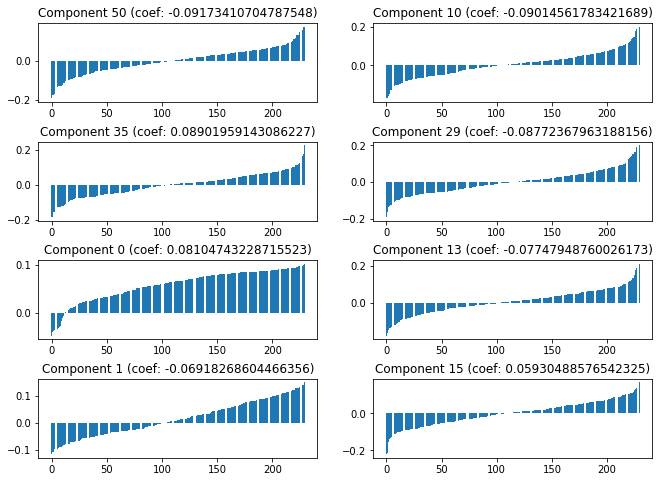

In [403]:
plt.figure(figsize=(11,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for position in np.arange(0, 8):
    component = temp.index[position]
    plt.subplot(4,2, position + 1)
    plt.bar(np.arange(0, pc.iloc[component].shape[0]), pc.iloc[component].sort_values())
    plt.title('Component {} (coef: {})'.format(component, pc.index[component]))

In [247]:
fitted.score(X_pca, y_digits)

0.90626824643063419

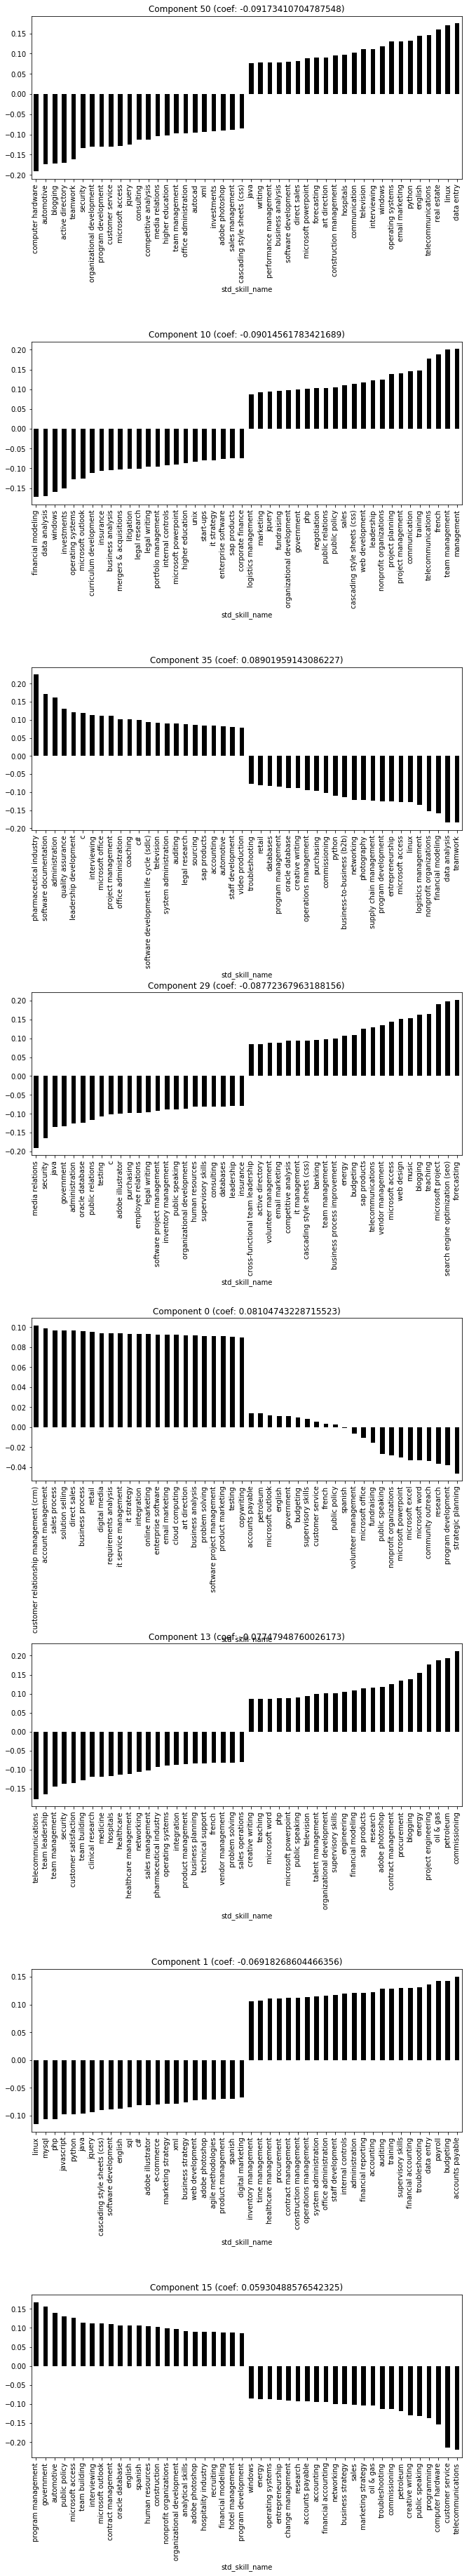

In [430]:
plt.figure(figsize=(11, 64))
plt.subplots_adjust(wspace=0.2, hspace=1.0)

components = pc.iloc[temp[0:8].index]
for i in np.arange(0, components.shape[0]):
    if pc.index[temp.index[i]] < 0:
        ascend = True
    else:
        ascend = False
    component = components.iloc[i].sort_values(ascending=ascend)
    component = component.iloc[0:23].append(component.iloc[-23:])
    plt.subplot(8,1, i + 1)
    component.plot.bar(colormap='gist_gray', 
                       title='Component {} (coef: {})'.format(temp.index[i], pc.index[temp.index[i]]))
